# Step 0: Python Package Installation

In [ ]:
%%bash
rm -Rf topquantmat/ && git clone https://github.com/quantummasterbarcelonacode/topquantmat.git&>log
cd topquantmat
bash pull_from_conda.sh
conda install -c conda-forge ipympl -y&>log

In [ ]:
from IPython.display import display, Math,Markdown #Allow to manipulate expressions and how to display them
import numpy as np  #Package for handling numerical math
import sympy as sp  #Package for handling symbolic  math
from sympy import Q #Q is a way to input constrains
from sympy import latex # Convert sympy expression into latex to render in display
from sympy import oo

#IMPORTANT
import MQSciTech.tutorial as my #A package build for this session. Feel free to explore it.
import qsymm        #Package to build models using symmetries

from google.colab import output
output.enable_custom_widget_manager()

#Matplot lib is the plottong library
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib widget

print(my.welcome)
def my_print(message):
  display(Markdown(message))
def print_eq(suffix, eq):
  display(Markdown(suffix + r" $%s$ "%latex(eq)))

def VelOP(Psi,E, coord_syst, vars ):
  D = sp.diff;  kron_delta=my.delta;
  dim = len(E);
  V = [ sp.eye(dim),sp.eye(dim) ]
  if coord_syst=="polar":
    k,phi= vars;
    for i,x in enumerate(vars):
      for m in range(dim):
        for n in range(dim):
          V[i][m,n]= D(E[m],x)* kron_delta(m,n) + (E[m]-E[n])*my.dot( Psi[m], D(Psi[n],x) );
    V[1]=V[1]/k;
    return [sp.simplify(V[0]),sp.simplify(V[1])]

# General Definitions

In [ ]:
my_print("**Cartesian momentum**")
k_x, k_y,k_z = sp.symbols(["k_x","k_y","k_z"], real=True);
momenta= sp.Array([k_x,k_y, k_z]);

print_eq(r"$\vec{k}=$",momenta);

In [ ]:
my_print("**Polar momentum**")
k     = sp.Symbol("k",positive=True);
phi   = sp.Symbol("phi",real=True);
polar =[ (  k_x,  k*sp.cos(phi) ) ,
         (  k_y,  k*sp.sin(phi) )
         ];
print_eq(r"$\vec{k}=$",[k*sp.cos(phi),k*sp.sin(phi),k_z]);

In [ ]:
my_print("**Pauli matrices**")
sig0 = sp.Matrix([[1,    0],[0   , 1]]);
sigx = sp.Matrix([[0,    1],[1   , 0]]);
sigy = sp.Matrix([[0,-sp.I],[sp.I, 0]]);
sigz = sp.Matrix([[1,    0],[0   ,-1]]);
spins= [sigx,sigy,sigz];

for i,spin in zip(('x','y','z'),spins):
  print_eq(r"$\sigma_{%s}=$"%i,spin);

# Graphene
In this section we will construct a symmetry-based model for graphene. We will start by defining the essential elements of the model.

## Geometry

In [ ]:
sites= ['a', 'b']
norbs=( ("a",1), ("b",1) )

my_print("**Lattice vectors**")
lat_vec= my.graphene.lat_vec;
for i,lat in enumerate(lat_vec):
  print_eq(r'$ \vec{a}_{%d}=$'%i,lat);

my_print("**Hopping vector**")
hop_v= -(lat_vec[0]+lat_vec[1])/3 ;
hopping_vectors = [ ( 'a', 'b', hop_v) ];
print_eq(r'$\vec{\delta}=$',hop_v);

## Symetries

**QSYMM** is a package that allow to build symmetry oerators and use them to build model. Graphene belongs to the spacegroup P6/mmm in the internationa notation or D$_{6h}$ in sconflies notation . This means, hexagonal translation and six-fold rotation, inversion, and time-reversal point gpoup symmetries.


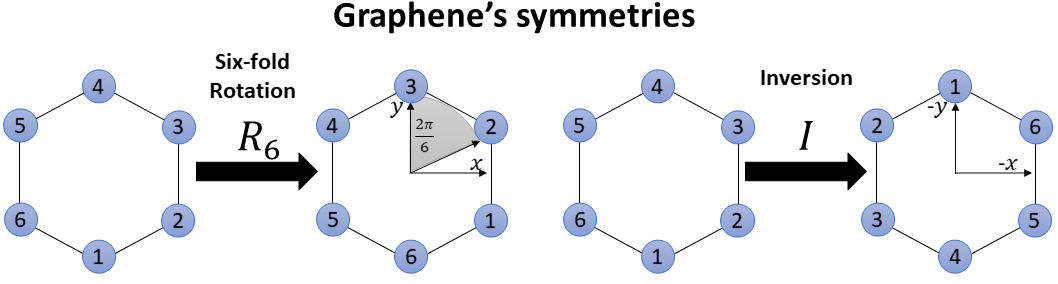

In [ ]:
my_print("**Rotation matrix**")
R = my.Rz(2*sp.pi/6);
print_eq(r'$R_6=$',R);
C6 = qsymm.groups.PointGroupElement(R ,U= np.array(sigx, dtype=int) )

my_print("**Inversion Matrix**")
I = qsymm.groups.inversion( realspace_dim= 3, U = np.array(sigx, dtype=int) );
print_eq(r'$I=$',sp.Matrix(I.R));

my_print("**Time Reversal Symmetry**")
TR= qsymm.time_reversal(realspace_dim=3,U= np.array(sig0, dtype=int) )
print_eq(r'${\rm TR}=K$',sp.Matrix(TR.R));

## Symmetry-based models

### The tight-binding

In [ ]:
#Determine the model using the symmetries
symmetries = [TR,C6,I];
E_0,t = sp.symbols(["varepsilon_0","t"], positive=True);
family= qsymm.bloch_family(hopping_vectors,symmetries, norbs, momenta=momenta,bloch_model=False);
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family).subs(*my.euler);
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family,coeffs=[E_0,t]).subs(*my.euler);

my_print("**The tight-binding model**")
print_eq("$H=$",gmodel)

**The Dispersion relation**

Simply by solving the expresion
det( H-E)=0, gives the *eigenenergies*

In [ ]:
my_print(r" Replace $\varepsilon_0\rightarrow 0$")
H = gmodel.subs(E_0,0);
my_print(r" Compute the eigenvalues")
Es= H.eigenvals();
Es= [ sp.trigsimp(E_k.rewrite(sp.cos)) for E_k in Es ];

for i,E_k in enumerate(Es):
  suffix = r"$E_{%d}(\vec{k})=$"%i
  print_eq( suffix,E_k)

In [ ]:
my_print(r" Replace $t\rightarrow 1$");
nEs= [ sp.lambdify( [k_x,k_y], E_k.subs(t,1) ) for E_k in Es ];

my_print(" The reciprocal lattice vectors");
rec_vec = 2*sp.pi*sp.Matrix(lat_vec).inv()
print_eq("$B=$", rec_vec)

my_print("**Numerical plot of Graphene's dispersion**");

fig = plt.figure();
ax = plt.axes(projection='3d');
ax.set_title('Graphene\'s dispersion ');
ax.set_xlabel(r'$k_x$'); ax.set_ylabel(r'$k_y$');
ax.set_zlabel(r'$E(\vec{k})$');

#Generate the numerical data
n=30;
for nE in nEs:
  #Compute the energies over the whole BZ
  xyz = [];
  for k_1 in np.linspace(0,1,n):
    for k_2 in np.linspace(0,1,n):
      kvec        = sp.Matrix([k_1,k_2,0]);
      nkx, nky,nkz= np.array( rec_vec*kvec ,dtype=float ).flatten();
      xyz.append( [nkx,nky,nE(nkx,nky)] );

  #Reshape the data by prepare
  KX,KY,Ek =[ x.reshape(n,n) for x in np.array(xyz).T];
  ax.plot_surface(KX,KY,Ek, rstride=1, cstride=1,
                  cmap='viridis', edgecolor='none');

### The low-energy $(\vec{k}\cdot\vec{p})$ Hamiltonian

In [ ]:
my_print(r"Replace $t\rightarrow 2v/\sqrt{3} $")
v = sp.Symbol("v", positive=True);
H = H.subs(t,2*v/sp.sqrt(3));

my_print(r"**Low energy Hamiltonians**")

R6 = my.Rz(2*sp.pi/6);

K0 = my.graphene.K0;
K1 = my.graphene.K1;

for sK, K in zip( (r"$\vec{K}_0$",r"$\vec{K}_1$"), (K0,K1) ):
  kpH = my.FirstOrderTaylor( H, x=momenta, x0=K  );
  print_eq(sK+"=", sp.Array(K) )
  print_eq(r"$H(\vec{k})=$", kpH );


 # hexagonal Boron-Nitride

We will use graphene as a basis and adjust the symmetries accordingly

## Geometry

In [ ]:
sites= ['a', 'b']
norbs=( ("a",1), ("b",1) )

my_print("**Lattice vectors**")
lat_vec= my.graphene.lat_vec;
for i,lat in enumerate(lat_vec):
  print_eq(r'$ \vec{a}_{%d}=$'%i,lat);

my_print("**Hopping vector**")
hop_v= -(lat_vec[0]+lat_vec[1])/3 ;
hopping_vectors = [ ( 'a', 'b', hop_v) ];
print_eq(r'$\vec{\delta}=$',hop_v);

## Symetries

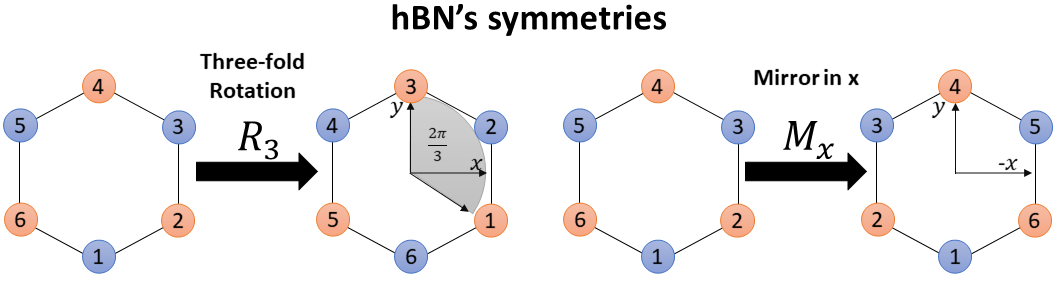

In [ ]:
my_print("**Rotation matrix**")
R = my.Rz(2*sp.pi/3);
print_eq(r'$R_3=$',R);
C3 = qsymm.groups.PointGroupElement(R ,U= np.array(sig0, dtype=int) )

my_print("**Mirror along $z$**")
R = sp.diag(1,1,-1);
print_eq(r'$M_z=$',R);
Mz= qsymm.groups.PointGroupElement(R ,U= np.array(sig0, dtype=int) )

my_print("**Mirror along $x$**")
R = sp.diag(-1,1,1);
print_eq(r'$M_x=$',R);
Mx= qsymm.groups.PointGroupElement(R ,U= np.array(sig0, dtype=int) )

my_print("**Time Reversal Symmetry**")
TR= qsymm.time_reversal(realspace_dim=3,U= np.array(sig0, dtype=int) )
print_eq(r'${\rm TR}=K$',sp.Matrix(TR.R));


## Symmetry-based models

### The tight-binding

In [ ]:
#Determine the model using the symmetries
symmetries = [C3,Mz,Mx,TR];
E_0,Delta,t = sp.symbols(["varepsilon_0","Delta","t"], positive=True);
family= qsymm.bloch_family(hopping_vectors,symmetries, norbs, momenta=momenta,bloch_model=False);
#gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family).subs(*my.euler);
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family,coeffs=[E_0-Delta,E_0+Delta,t]).subs(*my.euler);

my_print("**The tight-binding model**")
print_eq("$H=$",gmodel)

In [ ]:
my_print(r"**The dispersion relation**")
my_print(r" Replace $\varepsilon_0\rightarrow 0$")
H = gmodel.subs(E_0,0);

my_print(r" Compute the eigenvalues")
Es= H.eigenvals();
Es= [ sp.trigsimp(E_k.rewrite(sp.cos)) for E_k in Es ];

for i,E_k in enumerate(Es):
  suffix = r"$E_{%d}(\vec{k})=$"%i
  print_eq( suffix,E_k)

In [ ]:
my_print(r" Replace $t\rightarrow 1$");
nEs= [ sp.lambdify( [k_x,k_y], E_k.subs(t,1).subs(Delta,0.3) ) for E_k in Es ];

my_print(" The reciprocal lattice vectors");
rec_vec = 2*sp.pi*sp.Matrix(lat_vec).inv()
print_eq("$B=$", rec_vec)

my_print("**Numerical plot of Graphene's dispersion**");

fig = plt.figure();
ax = plt.axes(projection='3d');
ax.set_title('Graphene\'s dispersion ');
ax.set_xlabel(r'$k_x$'); ax.set_ylabel(r'$k_y$');
ax.set_zlabel(r'$E(\vec{k})$');

#Generate the numerical data
n=30;
for nE in nEs:
  #Compute the energies over the whole BZ
  xyz = [];
  for k_1 in np.linspace(0,1,n):
    for k_2 in np.linspace(0,1,n):
      kvec        = sp.Matrix([k_1,k_2,0]);
      nkx, nky,nkz= np.array( rec_vec*kvec ,dtype=float ).flatten();
      xyz.append( [nkx,nky,nE(nkx,nky)] );

  #Reshape the data by prepare
  KX,KY,Ek =[ x.reshape(n,n) for x in np.array(xyz).T];
  ax.plot_surface(KX,KY,Ek, rstride=1, cstride=1,
                  cmap='viridis', edgecolor='none');

### The low-energy $(\vec{k}\cdot\vec{p})$ Hamiltonian

In [ ]:
my_print(r"Replace $t\rightarrow 2v/\sqrt{3} $")
v= sp.Symbol("v", positive=True);
H = H.subs(t,2*v/sp.sqrt(3));

my_print(r"**Low energy Hamiltonians**")
for sK, K in zip( (r"$\vec{K}_0$",r"$\vec{K}_1$"),
                  (my.graphene.K0,my.graphene.K1)):
  kpH = my.FirstOrderTaylor( H, x=momenta, x0=K  );
  print_eq(sK+"=", sp.Array(K) )
  print_eq(r"$H(\vec{k})=$", kpH );

 ### Berry Curvature

We will define the foolowing variables: \\
$r_k = \sqrt{ \Delta^2 + k^2 v^2}$ \\
$\cos \theta_k = \Delta/r_k$ \\
$\sin \theta_k = kv/r_k$ \\
$\theta_k \in (0,\pi/2],\quad r_k>0$

In [ ]:
r_k, theta_k = sp.symbols(["r_k","theta_k"],positive=True);

expr_rK = sp.sqrt(Delta**2+k**2*v**2);
conv_polar = [( expr_rK , r_k ),
              ( k*v     , r_k*sp.sin(theta_k) ),
              ( Delta   , r_k*sp.cos(theta_k) ),
              ];
conv_cart  = [( r_k, expr_rK ),
              ( sp.sin(theta_k), k*v/expr_rK ),
              ( sp.cos(theta_k), Delta/expr_rK ),
              ( sp.sin(theta_k/2), (1/sp.sqrt(2))*sp.sqrt(1-Delta/expr_rK) ),
              ( sp.cos(theta_k/2), (1/sp.sqrt(2))*sp.sqrt(1+Delta/expr_rK) ),
              ];

In [ ]:
my_print("Computing the eigenvectors in polar coordinates")
kpH = my.FirstOrderTaylor( H, x=momenta, x0=my.graphene.K1  );
E,Psi_orig = my.EigenSystem(kpH,coord_syst=polar);
for i,x in enumerate(Psi_orig):
  Psi = r"$\Psi_%d(k,\phi)$="%i;
  print_eq(Psi, x.T)

my_print("Replace some variables for convenience")
Psi_vpol = [ my.half_angles( x.subs(conv_polar), theta_k) for x in Psi_orig];
for i,x in enumerate(Psi_vpol):
  expr1= sp.I * sp.sin(phi)- sp.cos(phi);
  expr2=-sp.exp(-sp.I*phi);
  Psi = r"$\Psi_%d(k,\phi)$="%i;
  x  = sp.simplify(x).subs(expr1,expr2);
  print_eq(Psi, x.T)

#### Velocity operator
$V_\alpha =\frac{1}{ i \hbar} \hbar [X_\alpha , H]$ \\
$V_\alpha =  [H , \partial_{k\alpha}]$ \\

$\langle m|\vec{V}|n\rangle=\delta_{mn}\vec{\nabla}_{k}\varepsilon_m + ( \varepsilon_m-\varepsilon_n )\langle m|\vec{\nabla}_{k}|n\rangle $

$\varepsilon_m\equiv \varepsilon_m(\vec{k})$

**In polar coordinates** \\
$\vec{\nabla} = \hat{u}_r \partial_r  + (1/r)\hat{u}_\phi\partial_\phi $




**Implementation in python** At the beginning of the notebook

































































































































































































































































































**The calculation**

In [ ]:
my_print("**Let us invert the k-dependent variables**")
Psi_vcar = [ my.exps2trig(sp.simplify(x.subs(conv_cart))) for x in Psi_vpol ];
for i,x in enumerate(Psi_vcar):
  psi = r"$\Psi_%d(k,\phi)$="%i;
  print_eq(psi, x.T)

my_print("**Compute the velocity in polar coordinates**")
v_k,v_phi = VelOP(Psi_vcar,E, "polar", [k,phi] );
v_k  = my.half_angles(sp.simplify(v_k.subs(conv_polar)), theta_k);
v_phi= my.half_angles(sp.simplify(v_phi.subs(conv_polar)),theta_k).subs(conv_cart);
for sv,vv in zip( (r"$V_k$",r"$V_\phi$"), (v_k,v_phi) ):
  print_eq(sv+"=",vv)

my_print("**Compute the velocity in cartesian coordinates**")
v_x =sp.simplify( v_k*sp.cos(phi)+ v_phi*sp.sin(phi) );
v_y =sp.simplify(-v_k*sp.sin(phi)+ v_phi*sp.cos(phi) );
for sv,vv in zip( (r"$V_x$",r"$V_y$"), (v_x,v_y) ):
  print_eq(sv+"=",sp.simplify(vv))


**The Berry Curvature**

$\Omega(\vec{k})= \sum_{n,m, n\neq m}2{\rm Im}\left[\frac{\langle n_k| V_x|m_k \rangle \langle m_k| V_y|n_k \rangle}{(\varepsilon_m(\vec{k})-\varepsilon_n(\vec{k}) )^2 } \right]$

In [ ]:
my_print("First we compute the Bery curvature")
Omega = 0;
for m in range(2):
  for n in range(2):
    if m != n:
      Omega =+ sp.simplify(2*sp.im( sp.simplify(v_x[n,m]*v_y[m,n]) ).subs(conv_cart)/(E[m]-E[n])**2);
print_eq(r"$\Omega(\vec{k})=$",Omega);

my_print("Then the chern number")
Chern = (1/sp.pi)*sp.integrate( sp.integrate( Omega*k , (phi,0,2*sp.pi) ), (k,-oo,0));
print_eq("$n=$",Chern);

In [ ]:
my_print("Finally the Hall conductivity")
mu = sp.Symbol("mu",negative=True);
sigma_xy = (1/sp.pi)*sp.integrate( sp.integrate( Omega*k , (phi,0,2*sp.pi) ), (k,-oo,mu) );
print_eq("$\sigma_{xy}(\mu)=$",sigma_xy);



#Assignment: Haldane Model

**Your turn!** We will use the knowledge to evaluate the Berry curvature of the Haldanene Model, which is simply graphene, without time-reversal symmetry, and *other* ingredients

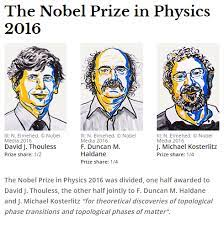

## Geometry

Please, copy here graphene's geometry, including two new hopping vectors:

('a','a', lat_vec[0]) a hopping from a to a

('b','b', lat_vec[0]) a hopping from b to b


In [ ]:
sites= ['a', 'b']
norbs=( ("a",1), ("b",1) )

my_print("**Lattice vectors**")
lat_vec= my.graphene.lat_vec;
for i,lat in enumerate(lat_vec):
  print_eq(r'$ \vec{a}_{%d}=$'%i,lat);

my_print("**Hopping vector**")
hop_v= -(lat_vec[0]+lat_vec[1])/3 ;
hopping_vectors = [ ( 'a', 'b', hop_v) ];
hopping_vectors = [ ( 'a', 'b', hop_v),( 'a', 'a', lat_vec[0]),( 'b', 'b', lat_vec[1]) ];
print_eq(r'$\vec{\delta}=$',hop_v);

## Symmetries and Symmetry-base model
* In a paper, determine graphene's symmetries.
* Copy here graphene's symmetries and use qsymm to build the model.
* For the model, define the positive symbols: varepsilon_0, t_1,t_2, lambda_H; \
and pass it to the hamiltonian generator as coeffs=[E_0,t_2,lambda_H,t_1]
* Print the Model
Dont forget the .subs(*my.euler)

In [ ]:
my_print("**Rotation matrix**")
R = my.Rz(2*sp.pi/6);
print_eq(r'$R_6=$',R);
C6 = qsymm.groups.PointGroupElement(R ,U= np.array(sigx, dtype=int) )

my_print("**Inversion Matrix**")
I = qsymm.groups.inversion( realspace_dim= 3, U = np.array(sigx, dtype=int) );
print_eq(r'$I=$',sp.Matrix(I.R));

my_print("**Time Reversal Symmetry**")
TR= qsymm.time_reversal(realspace_dim=3,U= np.array(sig0, dtype=int) )
print_eq(r'${\rm TR}=K$',sp.Matrix(TR.R));

In [ ]:
symmetries = [C6,I];
t_2,lambda_H,epsilon_0,t_1 = sp.symbols(["t_2","lambda_H","epsilon_0","t_1"], positive=True);
family= qsymm.bloch_family(hopping_vectors,symmetries, norbs, momenta=momenta,bloch_model=False);
print_eq("$f=$",len(family))
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family, coeffs=[t_2,lambda_H,epsilon_0,t_1]).subs(*my.euler);

my_print("**The tight-binding model**")
print_eq("$H=$",gmodel)

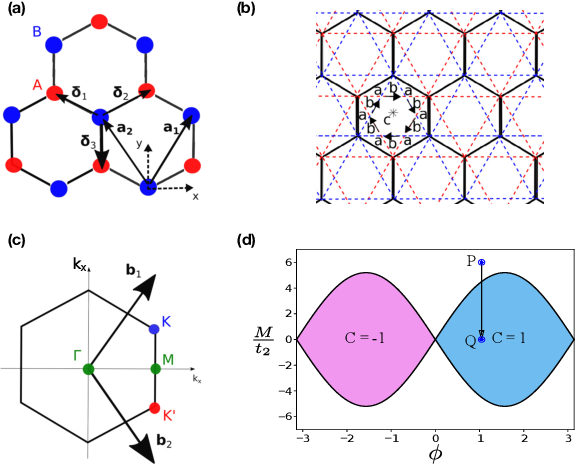

## Dispersion Relation
* Replace $\varepsilon_0\rightarrow 0$ and Replace $t_2 \rightarrow 0$
* Compute the eigenvalues
* Print the Dispersion relation

In [ ]:
my_print(r"**The dispersion relation**")
my_print(r" Replace $\varepsilon_0\rightarrow 0$ and Replace $t_2\rightarrow 0$")
H = gmodel.subs(epsilon_0,0).subs(t_2,0);

Es= H.eigenvals();
Es= [ sp.trigsimp(E_k.rewrite(sp.cos)) for E_k in Es ];

for i,E_k in enumerate(Es):
  suffix = r"$E_{%d}(\vec{k})=$"%i
  print_eq( suffix,E_k)

## The low-energy $(\vec{k}\cdot\vec{p})$ Hamiltonian
* Replace $t\rightarrow 2v/\sqrt{3} $ and $\lambda_H \rightarrow \Delta/3\sqrt{3} $
* Evaluate the low-energy Hamiltonian at the K points
* Compare the Hamiltonian with those previously obtained

In [ ]:
my_print(r"Replace $t\rightarrow 2v/\sqrt{3} $ and \lambda_H \rightarrow \Delta/3\sqrt{3}")
v, Delta= sp.symbols("v Delta", positive=True);
H = H.subs(t_1,2*v/sp.sqrt(3)).subs(lambda_H,Delta/sp.sqrt(3)/3);

my_print(r"**Low energy Hamiltonians**")
for sK, K in zip( (r"$\vec{K}_0$",r"$\vec{K}_1$"),
                  (my.graphene.K0,my.graphene.K1)):
  kpH = my.FirstOrderTaylor( H, x=momenta, x0=K  );
  print_eq(sK+"=", sp.Array(K) )
  print_eq(r"$H(\vec{k})=$", kpH );

## Berry Curvature
* Copy here conv_cart and conv_polar variables
* Compute the eigenvectors and express them in conv_polar
* Compute the velocity operator using the function we previously defined
* Compute the Chern number
* Does it change sign with valleys?

In [ ]:
r_k, theta_k = sp.symbols(["r_k","theta_k"],positive=True);

expr_rK = sp.sqrt(Delta**2+k**2*v**2);
conv_polar = [( expr_rK , r_k ),
              ( k*v     , r_k*sp.sin(theta_k) ),
              ( Delta   , r_k*sp.cos(theta_k) ),
              ];
conv_cart  = [( r_k, expr_rK ),
              ( sp.sin(theta_k), k*v/expr_rK ),
              ( sp.cos(theta_k), Delta/expr_rK ),
              ( sp.sin(theta_k/2), (1/sp.sqrt(2))*sp.sqrt(1-Delta/expr_rK) ),
              ( sp.cos(theta_k/2), (1/sp.sqrt(2))*sp.sqrt(1+Delta/expr_rK) ),
              ];


In [ ]:
my_print("Computing the eigenvectors in polar coordinates")
kpH = my.FirstOrderTaylor( H, x=momenta, x0=my.graphene.K1  );
E,Psi_orig = my.EigenSystem(kpH,coord_syst=polar);
for i,x in enumerate(Psi_orig):
  Psi = r"$\Psi_%d(k,\phi)$="%i;
  print_eq(Psi, x.T)

my_print("Replace some variables for convenience")
Psi_vpol = [ my.half_angles( x.subs(conv_polar), theta_k) for x in Psi_orig];
for i,x in enumerate(Psi_vpol):
  expr1= sp.I * sp.sin(phi)- sp.cos(phi);
  expr2=-sp.exp(-sp.I*phi);
  Psi = r"$\Psi_%d(k,\phi)$="%i;
  x  = sp.simplify(x).subs(expr1,expr2);
  print_eq(Psi, x.T)

In [ ]:
my_print("**Let us invert the k-dependent variables**")
Psi_vcar = [ my.exps2trig(sp.simplify(x.subs(conv_cart))) for x in Psi_vpol ];
for i,x in enumerate(Psi_vcar):
  psi = r"$\Psi_%d(k,\phi)$="%i;
  print_eq(psi, x.T)

my_print("**Compute the velocity in polar coordinates**")
v_k,v_phi = VelOP(Psi_vcar,E, "polar", [k,phi] );
v_k  = my.half_angles(sp.simplify(v_k.subs(conv_polar)), theta_k);
v_phi= my.half_angles(sp.simplify(v_phi.subs(conv_polar)),theta_k).subs(conv_cart);
for sv,vv in zip( (r"$V_k$",r"$V_\phi$"), (v_k,v_phi) ):
  print_eq(sv+"=",vv)

my_print("**Compute the velocity in cartesian coordinates**")
v_x =sp.simplify( v_k*sp.cos(phi)+ v_phi*sp.sin(phi) );
v_y =sp.simplify(-v_k*sp.sin(phi)+ v_phi*sp.cos(phi) );
for sv,vv in zip( (r"$V_x$",r"$V_y$"), (v_x,v_y) ):
  print_eq(sv+"=",sp.simplify(vv))

In [ ]:
my_print("First we compute the Bery curvature")
Omega = 0;
for m in range(2):
  for n in range(2):
    if m != n:
      Omega =+ sp.simplify(2*sp.im( sp.simplify(v_x[n,m]*v_y[m,n]) ).subs(conv_cart)/(E[m]-E[n])**2);
print_eq(r"$\Omega(\vec{k})=$",Omega);

my_print("Then the chern number")
Chern = (1/sp.pi)*sp.integrate( sp.integrate( Omega*k , (phi,0,2*sp.pi) ), (k,-oo,0));
print_eq("$n=$",Chern);

# The Kane-Melee model

## Geometry

In [ ]:
sites= ['a', 'b']
norbs=( ("a",2), ("b",2) )

my_print("**Lattice vectors**")
lat_vec= my.graphene.lat_vec;
for i,lat in enumerate(lat_vec):
  print_eq(r'$ \vec{a}_{%d}=$'%i,lat);

my_print("**Hopping vector**")
hop_v= -(lat_vec[0]+lat_vec[1])/3 ;
hopping_vectors = [ ( 'a', 'b', hop_v),( 'a', 'a', lat_vec[0]),( 'b', 'b', lat_vec[0]) ];
print_eq(r'$\vec{\delta}=$',lat);

S = qsymm.groups.spin_matrices(1/2);
Sx,Sy,Sz = S;

### Spinorial Physics

### Rotations

In [ ]:
Phi, Theta,alpha = sp.symbols("Phi Theta alpha", real=True);
my_print("The Spherical coordinates");
x= sp.cos(Phi)*sp.sin(Theta); print_eq("$\hat{x}=$",x)
y= sp.sin(Phi)*sp.sin(Theta); print_eq("$\hat{y}=$",y)
z= sp.cos(Theta);  print_eq("$\hat{z}=$",z)

su = sp.simplify(sigx*x/2 + sigy*y/2 + sigz*z/2 );
print_eq("$S_u=$",su)

RSu = sp.simplify(sp.exp(sp.I*su*alpha).rewrite(sp.cos)  );
print_eq("$R_u=$",RSu)
RSu

In [ ]:
qsymm.groups.spin_rotation(2*np.pi * np.array([0, 1/2, 0]), S)

### Mirrorr

In [ ]:

Mx = sigx;
print_eq("The mirror in x is $M_x=$",Mx);
for idx,s in zip(("x","y","z"),(sigx,sigy,sigz)):
  print_eq(r"$ \sigma_"+idx+r"=$",Mx*s*Mx)

My = sigy;
print_eq("The mirror in y is $M_y=$",My);
for idx,s in zip(("x","y","z"),(sigx,sigy,sigz)):
  print_eq(r"$ \sigma_"+idx+r"=$",My*s*My)

Mz = sigz;
print_eq("The mirror in z is $M_x=$",Mz);
for idx,s in zip(("x","y","z"),(sigx,sigy,sigz)):
  print_eq(r"$ \sigma_"+idx+r"=$",Mz*s*Mz)


TR = sigy;
print_eq("The time-reversal symmetry is $TR=$",TR);
for idx,s in zip(("x","y","z"),(sigx,sigy,sigz)):
  print_eq(r"$ \sigma_"+idx+r"=$",TR*s.conjugate()*TR)



### Our spin-pseudo spin convention (Due to QSYMM )

In [ ]:
from sympy.physics.quantum import TensorProduct as kronProd
display(kronProd(sig0,sigz))#Convention
display(np.kron(sig0,Sz).astype(float))

## Symmetries

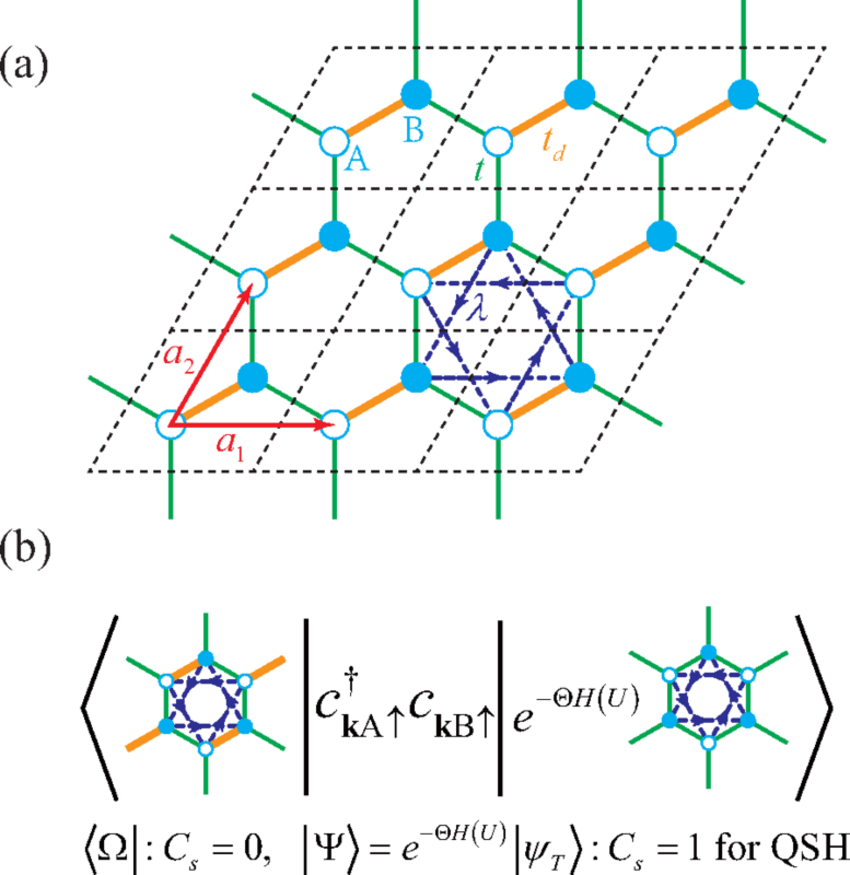

In [ ]:
my_print("**Rotation matrix**")
R = my.Rz(2*sp.pi/6);
U = np.kron( sigx, qsymm.groups.spin_rotation( [0, 0, 2*np.pi/6], S)).astype(complex);
C6 = qsymm.groups.PointGroupElement(R ,U=U )

my_print("**Inversion Matrix**")
U = np.kron( sigx, sig0).astype(float);
I = qsymm.groups.inversion( realspace_dim= 3, U = U );
print_eq(r'$I=$',sp.Matrix(I.R));

# Fermionic time-reversal
U = np.kron( sig0,qsymm.groups.spin_rotation(2*np.pi * np.array([0, 1/2, 0]), S)).astype(complex);
TR = qsymm.time_reversal( realspace_dim=3, U=U )

## Symmetry-based models

In [ ]:
symmetries = [C6,I,TR];
t_2,lambda_K,epsilon_0,t_1 = sp.symbols(["t_2","lambda_K","epsilon_0","t_1"], positive=True);
family= qsymm.bloch_family(hopping_vectors,symmetries, norbs, momenta=momenta,bloch_model=False);
print_eq("$f=$",len(family))
#gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family, coeffs=None).subs(*my.euler);
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family, coeffs=[epsilon_0,t_1,t_2,lambda_K]).subs(*my.euler);

my_print("**The tight-binding model**")
print_eq("$H=$",gmodel)

## The dispersion Relation

In [ ]:
my_print(r" Replace $\varepsilon_0\rightarrow 0$ and Replace $t_2\rightarrow 0$")
H = gmodel.subs(epsilon_0,0).subs(t_2,0);

Es= H.eigenvals();
Es= [ k for k in Es.keys() for i in range(Es[k]) ]
Es= [ sp.trigsimp(E_k.rewrite(sp.cos)) for E_k in Es ];

for i,E_k in enumerate(Es):
  suffix = r"$E_{%d}(\vec{k})=$"%i
  print_eq( suffix,E_k)

## The low-energy $(\vec{k}\cdot\vec{p})$ Hamiltonian

In [ ]:
my_print(r"Replace $t\rightarrow 2v/\sqrt{3} $ and \lambda_H \rightarrow \Delta/3\sqrt{3}")
v, Delta= sp.symbols("v Delta", positive=True);
H = H.subs(t_1,2*v/sp.sqrt(3)).subs(lambda_K,Delta/sp.sqrt(3)/3);

my_print(r"**Low energy Hamiltonians**")
for sK, K in zip( (r"$\vec{K}_0$",r"$\vec{K}_1$"),
                  (my.graphene.K0,my.graphene.K1)):
  kpH = my.FirstOrderTaylor( H, x=momenta, x0=K  );
  print_eq(sK+"=", sp.Array(K) )
  print_eq(r"$H(\vec{k})=$", kpH );

In [ ]:
my_print("Computing the eigenvectors in polar coordinates")
kpH = my.FirstOrderTaylor( H, x=momenta, x0=my.graphene.K0  );
E,Psi_orig = my.EigenSystem(kpH,coord_syst=polar);
for i,x in enumerate(Psi_orig):
  Psi = r"$\Psi_%d(k,\phi)$="%i;
  print_eq(Psi, x.T)

my_print("Replace some variables for convenience")
Psi_vpol = [ my.half_angles( x.subs(conv_polar), theta_k) for x in Psi_orig];
for i,x in enumerate(Psi_vpol):
  expr1= sp.I * sp.sin(phi)- sp.cos(phi);
  expr2=-sp.exp(-sp.I*phi);
  Psi = r"$\Psi_%d(k,\phi)$="%i;
  x  = sp.simplify(x).subs(expr1,expr2);
  print_eq(Psi, x.T)

## The Berry Curvature

In [ ]:
my_print("**Let us invert the k-dependent variables**")
Psi_vcar = [ my.exps2trig(sp.simplify(x.subs(conv_cart))) for x in Psi_vpol ];
for i,x in enumerate(Psi_vcar):
  psi = r"$\Psi_%d(k,\phi)$="%i;
  print_eq(psi, x.T)

my_print("**Compute the velocity in polar coordinates**")
v_k,v_phi = VelOP(Psi_vcar,E, "polar", [k,phi] );
v_k  = my.half_angles(sp.simplify(v_k.subs(conv_polar)), theta_k);
v_phi= my.half_angles(sp.simplify(v_phi.subs(conv_polar)),theta_k).subs(conv_cart);
for sv,vv in zip( (r"$V_k$",r"$V_\phi$"), (v_k,v_phi) ):
  print_eq(sv+"=",vv)

my_print("**Compute the velocity in cartesian coordinates**")
v_x =sp.simplify( v_k*sp.cos(phi)+ v_phi*sp.sin(phi) );
v_y =sp.simplify(-v_k*sp.sin(phi)+ v_phi*sp.cos(phi) );
for sv,vv in zip( (r"$V_x$",r"$V_y$"), (v_x,v_y) ):
  print_eq(sv+"=",sp.simplify(vv))

In [ ]:
my_print("First we compute the Bery curvature")
Omega = 0;
for m in range(0,4,2):
  for n in range(0,4,2):
    print(m,n)
    if E[m] != E[n]:
      Omega =+ sp.simplify(2*sp.im( sp.simplify(v_x[n,m]*v_y[m,n]) ).subs(conv_cart)/(E[m]-E[n])**2);
print_eq(r"$\Omega(\vec{k})=$",Omega);

my_print("Then the chern number")
Chern = (1/sp.pi)*sp.integrate( sp.integrate( Omega*k , (phi,0,2*sp.pi) ), (k,-oo,0));
print_eq("$n=$",Chern);

#The Rashba Effect in Graphene

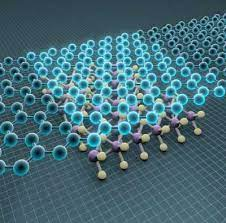

##Geometry

In [ ]:
sites= ['a', 'b']
norbs=( ("a",2), ("b",2) )

my_print("**Lattice vectors**")
lat_vec= my.graphene.lat_vec;
for i,lat in enumerate(lat_vec):
  print_eq(r'$ \vec{a}_{%d}=$'%i,lat);

my_print("**Hopping vector**")
hop_v= -(lat_vec[0]+lat_vec[1])/3 ;
hopping_vectors = [ ( 'a', 'b', hop_v) ];
print_eq(r'$\vec{\delta}=$',lat);

## Symmetries

In [ ]:
my_print("**Rotation matrix**")
R = my.Rz(2*sp.pi/6);
U = np.kron( sigx, qsymm.groups.spin_rotation( [0, 0, 2*np.pi/6], S)).astype(complex);
print_eq(r'$R_6=$',R);
C6 = qsymm.groups.PointGroupElement(R ,U=U )

my_print("**Mirror along $x$**")
R = sp.diag(-1,1,1);
U = np.kron( sig0, sigx ).astype(float)
print_eq(r'$M_x=$',R);
Mx= qsymm.groups.PointGroupElement(R ,U= U )


my_print("**Mirror along $y$**")
R = sp.diag(1,-1,1);
U = np.kron( sigx,sigy).astype(complex)
print_eq(r'$M_y=$',R);
My= qsymm.groups.PointGroupElement(R ,U= U )

my_print("**Mirror along $z$**")
R = sp.diag(1, 1,-1);
U = np.kron( sig0,sigz).astype(float)
print_eq(r'$M_z=$',R);
Mz= qsymm.groups.PointGroupElement(R ,U= U )


my_print("**Inversion Matrix**")
U = np.kron( sigx, sig0).astype(float);
I = qsymm.groups.inversion( realspace_dim= 3, U = U );
print_eq(r'$I=$',sp.Matrix(I.R));

# Fermionic time-reversal
U = np.kron( sig0,-sp.I*sigy ).astype(float);
TR = qsymm.time_reversal( realspace_dim=3, U=U )

## Symmetry-based model

In [ ]:
symmetries = [C6,I,TR];
symmetries = [Mx,My,TR,C6];
E_0,t,lambda_R = sp.symbols(["epsilon_0","t_1", "lambda_R"], positive=True);
family= qsymm.bloch_family(hopping_vectors,symmetries, norbs, momenta=momenta,bloch_model=False);
print_eq("$f=$",len(family))
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family, coeffs=None).subs(*my.euler);
gmodel =qsymm.hamiltonian_generator.hamiltonian_from_family(family, coeffs=[E_0,t,lambda_R]).subs(*my.euler);

my_print("**The tight-binding model**")
print_eq("$H=$",gmodel)

In [ ]:
my_print(r" Replace $\varepsilon_0\rightarrow 0$ and Replace $t_2\rightarrow 0$")
H = gmodel.subs(E_0,0).subs(t_2,0);

Es= H.eigenvals();
Es= [ k for k in Es.keys() for i in range(Es[k]) ]
Es= [ sp.trigsimp(E_k.rewrite(sp.cos)) for E_k in Es ];

for i,E_k in enumerate(Es):
  suffix = r"$E_{%d}(\vec{k})=$"%i
  print_eq( suffix,E_k)

##The low-energy $(\vec{k}\cdot\vec{p})$ Hamiltonian

In [ ]:
my_print(r"Replace $t\rightarrow 2v/\sqrt{3} $ and \lambda_H \rightarrow \Delta/3\sqrt{3}")
v, Delta= sp.symbols("v Delta", positive=True);
H = H.subs(t,2*v/sp.sqrt(3)).subs(E_0,0);

my_print(r"**Low energy Hamiltonians**")
for sK, K in zip( (r"$\vec{K}_0$",r"$\vec{K}_1$"),
                  (my.graphene.K0,my.graphene.K1)):
  kpH = my.FirstOrderTaylor( H, x=momenta, x0=K  );
  print_eq(sK+"=", sp.Array(K) )
  print_eq(r"$H(\vec{k})=$", kpH );

In [ ]:
from sympy.physics.quantum import TensorProduct
(kronProd(sigx,sigy)+kronProd(sigy,sigx)) *lambda_R*sp.sqrt(3)

In [ ]:
(kronProd(sigx,sigy)-kronProd(sigy,sigx)) *lambda_R*sp.sqrt(3)